Compare HEMnet predictions to sequencing estimates of tumour purity

In [3]:
import cv2 as cv
import importlib
import io
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import multiprocessing as mp
import numpy as np
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw
import scipy as sp
import seaborn as sns
import sys
import time
import timeit

In [10]:
# Input Paths
HEMNET_PREDICTIONS_PATH = Path('/gpfs1/scratch/90days/s4436005/TCGA/03_08_20_v2/Slide_Predictions.csv')
TUMOUR_PURITY_PATH = Path('/gpfs1/scratch/90days/s4436005/TCGA/COAD_tumor_purity.txt')
TP53_PATH = Path('/QRISdata/Q1139/ST_Projects/HEMnet/HEMnet_Data/TCGA/COAD/samples_with_TP53.txt')
# OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/03_08_20_testing')
OUTPUT_PATH = Path('/QRISdata/Q1139/ST_Projects/HEMnet/Figure_Data/TCGA_Validation')

VERBOSE = True

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi, bbox_inches = 'tight')
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

In [52]:
# Load HEMnet predictions and sequencing estimates of tumour purity
hemnet_preds = pd.read_csv(HEMNET_PREDICTIONS_PATH, index_col = 0)
tumour_purity = pd.read_csv(TUMOUR_PURITY_PATH, sep = '\t')
tp53 = pd.read_csv(TP53_PATH, sep = '\t', header=None)

## Preprocess HEMnet Predictions

In [13]:
hemnet_preds.head()

,Slide_Name,WSI_Area_mm^2,Tissue_Area_mm^2,Tiles,Cancer_Tiles,Cancer_Tile_Proportion,Average_Sigmoid_Value,Weighted_Average_Sigmoid_Value,Cancer_Area_Proportion
TCGA-D5-6928-01A-01-BS1,TCGA-D5-6928-01A-01-BS1.9e649367-15d6-40f4-8c7...,77.220275,38.040677,1003,745,0.742772,0.709082,0.751784,0.796016
TCGA-CK-5913-01A-01-TS1,TCGA-CK-5913-01A-01-TS1.d2ffb454-f0de-4538-953...,35.427485,11.583485,317,262,0.826498,0.780951,0.881135,0.937466
TCGA-AA-3663-01A-01-BS1,TCGA-AA-3663-01A-01-BS1.29369de3-d3c2-4712-a8d...,77.251431,19.192665,633,451,0.712480,0.675050,0.792057,0.860793
TCGA-AZ-5403-01A-01-TS1,TCGA-AZ-5403-01A-01-TS1.52f83f14-e748-4607-a3c...,145.184997,28.027916,1080,748,0.692593,0.655301,0.735446,0.810626
TCGA-F4-6856-01Z-00-DX1,TCGA-F4-6856-01Z-00-DX1.2872c7b5-b94d-4147-ad9...,424.598514,174.409418,4971,385,0.077449,0.113599,0.119360,0.088332


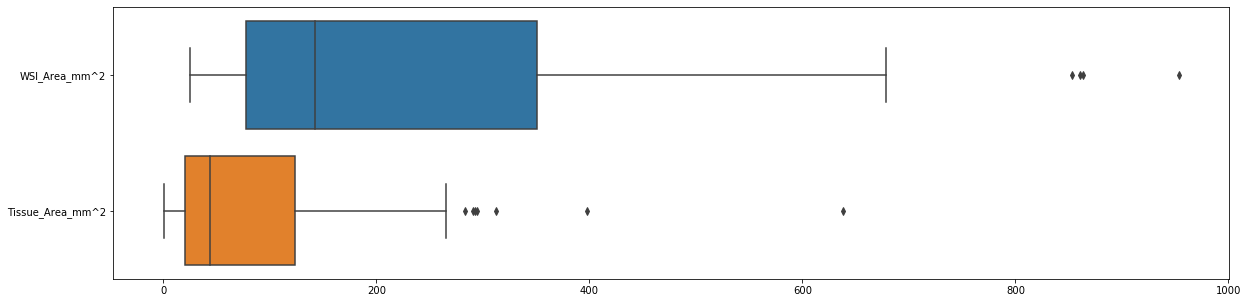

In [14]:
# Plot distribution of slide area and tissue area
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,5))
sns.boxplot(data = hemnet_preds[['WSI_Area_mm^2', 'Tissue_Area_mm^2']], orient = 'h', ax = ax)

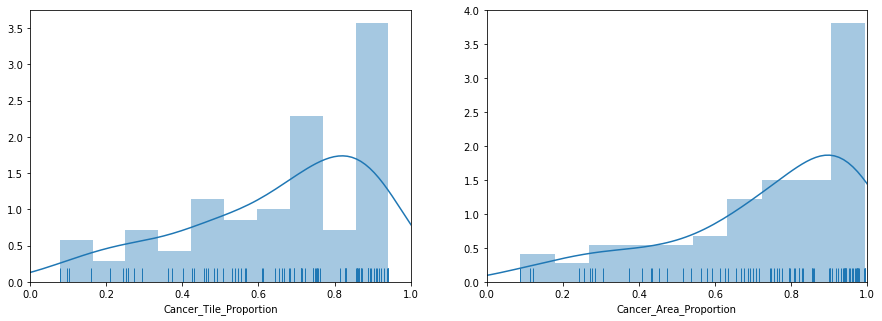

In [15]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
sns.distplot(hemnet_preds['Cancer_Tile_Proportion'], rug = True, bins = 10, ax = axs[0])
sns.distplot(hemnet_preds['Cancer_Area_Proportion'], rug = True, bins = 10, ax = axs[1])
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1);

In [16]:
slide_metadata = [x.split('-') for x in hemnet_preds.index.values]
# hemnet_ids = [f'{b}-{c}-{d}' for a, b, c, d, e, f in slide_metadata]
hemnet_ids = [f'{b}-{c}' for a, b, c, d, e, f in slide_metadata]
# TS, BS indicate frozen slides and DX indicates FFPE slides
# TS - Top Slide, BS - Bottom Slide, DX - Diagnostic Slide
# TS and BS are used in surgery to check resection margins 
slide_types = [f for a, b, c, d, e, f in slide_metadata]
len(hemnet_ids)

81

In [17]:
#hemnet_preds = hemnet_preds.reset_index()
hemnet_preds['ID'] = hemnet_ids
hemnet_preds['Slide_Type'] = slide_types
#hemnet_preds = hemnet_preds.set_index('ID')
hemnet_preds.head()

,Slide_Name,WSI_Area_mm^2,Tissue_Area_mm^2,Tiles,Cancer_Tiles,Cancer_Tile_Proportion,Average_Sigmoid_Value,Weighted_Average_Sigmoid_Value,Cancer_Area_Proportion,ID,Slide_Type
TCGA-D5-6928-01A-01-BS1,TCGA-D5-6928-01A-01-BS1.9e649367-15d6-40f4-8c7...,77.220275,38.040677,1003,745,0.742772,0.709082,0.751784,0.796016,D5-6928,BS1
TCGA-CK-5913-01A-01-TS1,TCGA-CK-5913-01A-01-TS1.d2ffb454-f0de-4538-953...,35.427485,11.583485,317,262,0.826498,0.780951,0.881135,0.937466,CK-5913,TS1
TCGA-AA-3663-01A-01-BS1,TCGA-AA-3663-01A-01-BS1.29369de3-d3c2-4712-a8d...,77.251431,19.192665,633,451,0.712480,0.675050,0.792057,0.860793,AA-3663,BS1
TCGA-AZ-5403-01A-01-TS1,TCGA-AZ-5403-01A-01-TS1.52f83f14-e748-4607-a3c...,145.184997,28.027916,1080,748,0.692593,0.655301,0.735446,0.810626,AZ-5403,TS1
TCGA-F4-6856-01Z-00-DX1,TCGA-F4-6856-01Z-00-DX1.2872c7b5-b94d-4147-ad9...,424.598514,174.409418,4971,385,0.077449,0.113599,0.119360,0.088332,F4-6856,DX1


Text(0.5, 1.0, 'Comparison of Tissue Area vs Slide Type')

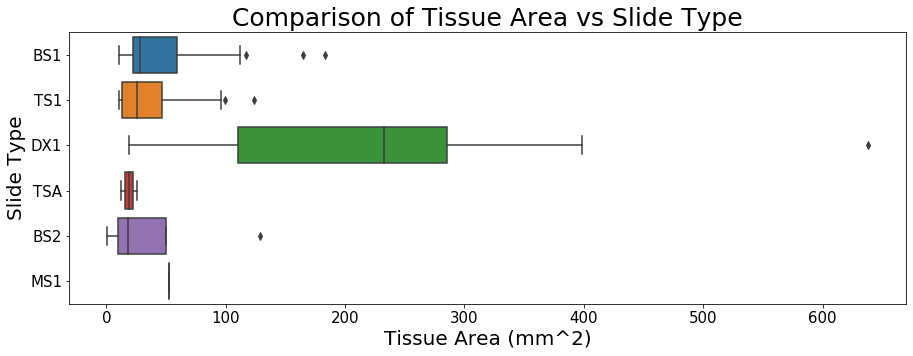

In [18]:
# Compare Tissue vs Slide type
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5))
sns.boxplot(x = 'Tissue_Area_mm^2', y = 'Slide_Type', data = hemnet_preds, orient = 'h', ax = ax)
ax.set_xlabel('Tissue Area (mm^2)', fontsize=20)
ax.set_ylabel('Slide Type', fontsize = 20)
ax.tick_params('both', labelsize=15)
ax.set_title('Comparison of Tissue Area vs Slide Type', fontsize=25)

In [19]:
# Select particular slide type
hemnet_preds_filtered = hemnet_preds.loc[hemnet_preds['Slide_Type'] == 'DX1']
# hemnet_preds_filtered = hemnet_preds.loc[(hemnet_preds['Slide_Type'] == 'BS1') | (hemnet_preds['Slide_Type'] == 'TS1') | (hemnet_preds['Slide_Type'] == 'BS2')]
# hemnet_preds_filtered = hemnet_preds.loc[(hemnet_preds['Slide_Type'] == 'BS1')]
# hemnet_preds_filtered = hemnet_preds

In [20]:
hemnet_preds_filtered

,Slide_Name,WSI_Area_mm^2,Tissue_Area_mm^2,Tiles,Cancer_Tiles,Cancer_Tile_Proportion,Average_Sigmoid_Value,Weighted_Average_Sigmoid_Value,Cancer_Area_Proportion,ID,Slide_Type
TCGA-F4-6856-01Z-00-DX1,TCGA-F4-6856-01Z-00-DX1.2872c7b5-b94d-4147-ad9...,424.598514,174.409418,4971,385,0.077449,0.113599,0.119360,0.088332,F4-6856,DX1
TCGA-AD-6889-01Z-00-DX1,TCGA-AD-6889-01Z-00-DX1.5269A81E-5391-4875-8F2...,220.427871,121.542617,3032,2764,0.911609,0.913845,0.988469,0.993960,AD-6889,DX1
TCGA-G4-6307-01Z-00-DX1,TCGA-G4-6307-01Z-00-DX1.fff548a0-8bc8-428e-a4c...,410.881853,215.085508,5228,3369,0.644415,0.657372,0.667319,0.655911,G4-6307,DX1
TCGA-CM-6677-01Z-00-DX1,TCGA-CM-6677-01Z-00-DX1.e3428c0a-a194-4e38-b10...,678.275733,292.761873,7136,3443,0.482483,0.480912,0.553507,0.562710,CM-6677,DX1
TCGA-D5-5537-01Z-00-DX1,TCGA-D5-5537-01Z-00-DX1.14709d4c-eba0-48d0-87b...,953.167098,240.050099,7030,3210,0.456615,0.478683,0.627664,0.625160,D5-5537,DX1
TCGA-CK-5913-01Z-00-DX1,TCGA-CK-5913-01Z-00-DX1.64d267c5-895f-4274-9d9...,488.024176,291.187584,7160,3044,0.425140,0.439001,0.481065,0.474003,CK-5913,DX1
TCGA-CK-5914-01Z-00-DX1,TCGA-CK-5914-01Z-00-DX1.dfa6d814-6ddb-4058-a23...,504.167705,221.807482,5200,3705,0.712500,0.721869,0.751432,0.744891,CK-5914,DX1
TCGA-AZ-5403-01Z-00-DX1,TCGA-AZ-5403-01Z-00-DX1.1c557fea-6627-48e9-abb...,852.984560,638.188401,13865,3567,0.257266,0.285828,0.298597,0.270921,AZ-5403,DX1
TCGA-CK-6747-01Z-00-DX1,TCGA-CK-6747-01Z-00-DX1.7824596c-84db-4bee-b14...,580.797804,265.622753,6853,3680,0.536991,0.546141,0.637273,0.633882,CK-6747,DX1
TCGA-A6-5656-01Z-00-DX1,TCGA-A6-5656-01Z-00-DX1.8a8ebf52-8217-4288-888...,261.263280,18.582312,529,470,0.888469,0.881185,0.981599,0.994096,A6-5656,DX1


In [21]:
# Check if all index values are unique
verbose_print(hemnet_preds_filtered.index.is_unique)
verbose_print(len(hemnet_preds_filtered))

hemnet_preds_filtered = hemnet_preds_filtered.groupby(['ID']).mean()

# Check if all index values are unique
verbose_print(hemnet_preds_filtered.index.is_unique)
verbose_print(len(hemnet_preds_filtered))

True
24
True
24


In [22]:
# Set ID as index 
hemnet_preds_filtered = hemnet_preds_filtered.reset_index()
hemnet_preds_filtered = hemnet_preds_filtered.set_index('ID')
hemnet_preds_filtered.head()

,WSI_Area_mm^2,Tissue_Area_mm^2,Tiles,Cancer_Tiles,Cancer_Tile_Proportion,Average_Sigmoid_Value,Weighted_Average_Sigmoid_Value,Cancer_Area_Proportion
ID,,,,,,,,
A6-5656,261.263280,18.582312,529,470,0.888469,0.881185,0.981599,0.994096
A6-6650,448.667800,76.959151,1901,1633,0.859022,0.859600,0.950363,0.959655
AA-3715,318.484992,74.106151,7886,6533,0.828430,0.798354,0.867347,0.906945
AA-3973,127.581053,44.203969,4919,3363,0.683676,0.672533,0.676276,0.690780
AD-6889,220.427871,121.542617,3032,2764,0.911609,0.913845,0.988469,0.993960


## Preprocess sequencing estimates of tumour purity

In [23]:
tumour_purity.head()

,#Sample ID,Cancer type,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,num_subpop,expands,infinium,Purity_ABSOLUTE
0,TCGA-3L-AA1B-01A,COAD,0.9025,NaN,0.6238,0.70,0.7913,4.0,0.445976,0.53,-
1,TCGA-4N-A93T-01A,COAD,0.9752,NaN,0.7915,0.75,0.7898,4.0,0.957717,0.75,-
2,TCGA-4T-AA8H-01A,COAD,0.9865,NaN,NaN,0.60,0.8917,4.0,0.495473,NaN,NaN
3,TCGA-5M-AAT4-01A,COAD,0.9720,NaN,NaN,0.70,0.8372,8.0,0.954421,NaN,NaN
4,TCGA-5M-AAT5-01A,COAD,0.9752,NaN,NaN,0.75,0.8170,NaN,NaN,NaN,NaN


In [24]:
# Replace dash with NaN
tumour_purity = tumour_purity.replace('-', np.nan)
tumour_purity.head()

,#Sample ID,Cancer type,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,num_subpop,expands,infinium,Purity_ABSOLUTE
0,TCGA-3L-AA1B-01A,COAD,0.9025,NaN,0.6238,0.70,0.7913,4.0,0.445976,0.53,NaN
1,TCGA-4N-A93T-01A,COAD,0.9752,NaN,0.7915,0.75,0.7898,4.0,0.957717,0.75,NaN
2,TCGA-4T-AA8H-01A,COAD,0.9865,NaN,NaN,0.60,0.8917,4.0,0.495473,NaN,NaN
3,TCGA-5M-AAT4-01A,COAD,0.9720,NaN,NaN,0.70,0.8372,8.0,0.954421,NaN,NaN
4,TCGA-5M-AAT5-01A,COAD,0.9752,NaN,NaN,0.75,0.8170,NaN,NaN,NaN,NaN


In [25]:
tumour_purity['Purity_ABSOLUTE'] = tumour_purity['Purity_ABSOLUTE'].astype(np.float64)
tumour_purity.dtypes

#Sample ID          object
Cancer type         object
ESTIMATE           float64
ABSOLUTE           float64
LUMP               float64
IHC                float64
CPE                float64
num_subpop         float64
expands            float64
infinium           float64
Purity_ABSOLUTE    float64
dtype: object

In [26]:
tumour_purity_ids = [x.split('-')[1:4] for x in tumour_purity['#Sample ID'].values]
# tumour_purity_ids = [f'{x}-{y}-{z}' for x,y,z in tumour_purity_ids]
tumour_purity_ids = [f'{x}-{y}' for x,y,z in tumour_purity_ids]
tumour_purity_ids

['3L-AA1B',
 '4N-A93T',
 '4T-AA8H',
 '5M-AAT4',
 '5M-AAT5',
 '5M-AAT6',
 '5M-AATA',
 '5M-AATE',
 'A6-2670',
 'A6-2671',
 'A6-2672',
 'A6-2674',
 'A6-2674',
 'A6-2675',
 'A6-2676',
 'A6-2677',
 'A6-2677',
 'A6-2678',
 'A6-2679',
 'A6-2680',
 'A6-2681',
 'A6-2682',
 'A6-2683',
 'A6-2684',
 'A6-2684',
 'A6-2685',
 'A6-2686',
 'A6-3807',
 'A6-3808',
 'A6-3809',
 'A6-3809',
 'A6-3810',
 'A6-3810',
 'A6-4105',
 'A6-4107',
 'A6-5656',
 'A6-5656',
 'A6-5657',
 'A6-5659',
 'A6-5659',
 'A6-5660',
 'A6-5661',
 'A6-5661',
 'A6-5662',
 'A6-5664',
 'A6-5665',
 'A6-5665',
 'A6-5666',
 'A6-5667',
 'A6-6137',
 'A6-6138',
 'A6-6140',
 'A6-6141',
 'A6-6142',
 'A6-6648',
 'A6-6649',
 'A6-6650',
 'A6-6650',
 'A6-6651',
 'A6-6652',
 'A6-6653',
 'A6-6654',
 'A6-6780',
 'A6-6780',
 'A6-6781',
 'A6-6781',
 'A6-6782',
 'A6-A565',
 'A6-A566',
 'A6-A567',
 'A6-A56B',
 'A6-A5ZU',
 'AA-3488',
 'AA-3489',
 'AA-3492',
 'AA-3494',
 'AA-3495',
 'AA-3496',
 'AA-3502',
 'AA-3506',
 'AA-3509',
 'AA-3510',
 'AA-3511',
 'AA

In [27]:
tumour_purity = tumour_purity.reset_index()
tumour_purity['ID'] = tumour_purity_ids
tumour_purity = tumour_purity.set_index('ID')
tumour_purity.head()

,index,#Sample ID,Cancer type,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,num_subpop,expands,infinium,Purity_ABSOLUTE
ID,,,,,,,,,,,,
3L-AA1B,0,TCGA-3L-AA1B-01A,COAD,0.9025,NaN,0.6238,0.70,0.7913,4.0,0.445976,0.53,NaN
4N-A93T,1,TCGA-4N-A93T-01A,COAD,0.9752,NaN,0.7915,0.75,0.7898,4.0,0.957717,0.75,NaN
4T-AA8H,2,TCGA-4T-AA8H-01A,COAD,0.9865,NaN,NaN,0.60,0.8917,4.0,0.495473,NaN,NaN
5M-AAT4,3,TCGA-5M-AAT4-01A,COAD,0.9720,NaN,NaN,0.70,0.8372,8.0,0.954421,NaN,NaN
5M-AAT5,4,TCGA-5M-AAT5-01A,COAD,0.9752,NaN,NaN,0.75,0.8170,NaN,NaN,NaN,NaN


In [28]:
# Check if all index values are unique
verbose_print(tumour_purity.index.is_unique)
verbose_print(len(tumour_purity))

tumour_purity_filtered = tumour_purity.groupby(['ID']).mean()

# Check if all index values are unique
verbose_print(tumour_purity_filtered.index.is_unique)
verbose_print(len(tumour_purity_filtered))

False
476
True
462


## Preprocess TP53 status of each sample

In [53]:
tp53.head()

,0,1,2,3,4
0,TCGA-AD-6901-01A-11D-1924-10,Missense_Mutation,7674935,C,C
1,TCGA-AA-3673-01A-01W-0900-09,Splice_Region,7675994,C,C
2,TCGA-AA-3975-01A-01W-0995-10,Missense_Mutation,7673796,C,C
3,TCGA-AM-5821-01A-01D-1650-10,Missense_Mutation,7673803,G,G
4,TCGA-AA-3858-01A-01W-0900-09,Frame_Shift_Ins,7676265,-,-


In [54]:
tp53_ids = [x.split('-')[1:4] for x in tp53[0].values]
tp53_ids = [f'{x}-{y}' for x,y,z in tp53_ids]
tp53_ids

['AD-6901',
 'AA-3673',
 'AA-3975',
 'AM-5821',
 'AA-3858',
 'AY-A54L',
 'AA-3941',
 'NH-A50V',
 'G4-6303',
 'AD-6888',
 'CA-6719',
 'D5-6898',
 'DM-A1D4',
 'AA-3971',
 'AA-A010',
 '5M-AAT5',
 'AA-A01Z',
 'A6-6137',
 'AZ-6605',
 'SS-A7HO',
 'AA-A02F',
 'AA-3655',
 'DM-A28H',
 'QG-A5YV',
 'G4-6317',
 'G4-6311',
 'AA-3856',
 'AA-3866',
 'AY-5543',
 'AA-3511',
 'AA-A017',
 'AA-3842',
 'AA-3862',
 'G4-6320',
 'QG-A5YW',
 'A6-6652',
 'CK-4948',
 'CK-4951',
 'CK-5914',
 'F4-6854',
 'F4-6854',
 'A6-6650',
 'A6-2685',
 'AA-3977',
 'AZ-6600',
 'AA-3967',
 'NH-A6GB',
 'A6-2686',
 'CM-4746',
 'G4-6306',
 'CM-6677',
 'CA-6718',
 'CA-6718',
 'DM-A1D7',
 'AA-A02H',
 'AY-4070',
 'A6-3807',
 'AZ-6607',
 'CM-6165',
 'AA-3666',
 'AD-6548',
 'AA-3848',
 'A6-A567',
 'D5-6540',
 'AA-3662',
 'D5-6538',
 'G4-6625',
 'G4-6297',
 'CM-6163',
 'AZ-6608',
 'NH-A8F8',
 'NH-A50U',
 'NH-A6GC',
 'F4-6856',
 'DM-A28F',
 'CM-4751',
 'NH-A5IV',
 'AA-A02K',
 '4N-A93T',
 'D5-6532',
 'AA-3877',
 'CM-5862',
 'AA-3851',
 'AA

In [63]:
tp53 = tp53.reset_index(drop=True)
tp53['ID'] = tp53_ids
tp53 = tp53.set_index('ID')
tp53 = tp53.rename(columns={0: 'Sample_ID', 1: 'Mutation_Type'})
tp53.head()

,Sample_ID,Mutation_Type,2,3,4
ID,,,,,
AD-6901,TCGA-AD-6901-01A-11D-1924-10,Missense_Mutation,7674935,C,C
AA-3673,TCGA-AA-3673-01A-01W-0900-09,Splice_Region,7675994,C,C
AA-3975,TCGA-AA-3975-01A-01W-0995-10,Missense_Mutation,7673796,C,C
AM-5821,TCGA-AM-5821-01A-01D-1650-10,Missense_Mutation,7673803,G,G
AA-3858,TCGA-AA-3858-01A-01W-0900-09,Frame_Shift_Ins,7676265,-,-


In [138]:
verbose_print(tp53.index.is_unique)
verbose_print(len(tp53))

tp53_filtered = tp53.groupby(['ID']).first()

# Check if all index values are unique
verbose_print(tp53_filtered.index.is_unique)
verbose_print(len(tp53_filtered))

False
229
True
218


In [139]:
tp53[tp53.index.isin(hemnet_ids)]

,Sample_ID,Mutation_Type,2,3,4
ID,,,,,
AA-3511,TCGA-AA-3511-01A-21D-1835-10,Missense_Mutation,7674230,C,C
CK-5914,TCGA-CK-5914-01A-11D-1650-10,Missense_Mutation,7674220,C,C
A6-6650,TCGA-A6-6650-01A-11D-1771-10,Missense_Mutation,7675088,C,C
CM-6677,TCGA-CM-6677-01A-11D-1835-10,Missense_Mutation,7673776,G,G
F4-6856,TCGA-F4-6856-01A-11D-1924-10,Nonsense_Mutation,7673704,G,G
G4-6307,TCGA-G4-6307-01A-11D-1719-10,Missense_Mutation,7674188,C,C
AA-3492,TCGA-AA-3492-01A-01D-1408-10,Frame_Shift_Del,7673718,G,G
AA-3492,TCGA-AA-3492-01A-01D-1408-10,5'UTR,7676604,C,C
AZ-5403,TCGA-AZ-5403-01A-01D-1650-10,Splice_Site,7675052,C,C


In [140]:
# tp53_filtered.loc['AZ-5403']
# tp53_filtered.loc['AA-3492']
tp53_filtered.loc['AZ-5403', 'Mutation_Type'] = 'Missense_Mutation'

In [141]:
tp53_filtered.loc['AZ-5403']

Sample_ID        TCGA-AZ-5403-01A-01D-1650-10
Mutation_Type               Missense_Mutation
2                                     7675052
3                                           C
4                                           C
Name: AZ-5403, dtype: object

## Compare HEMnet predictions with sequencing estimates of tumour purity

In [142]:
seq_combined = pd.concat([tumour_purity_filtered, tp53_filtered], axis=1, join='outer', sort='True')

In [143]:
seq_combined['Mutation_Type'] = seq_combined['Mutation_Type'].fillna('None')

In [144]:
seq_combined.head()

,index,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,num_subpop,expands,infinium,Purity_ABSOLUTE,Sample_ID,Mutation_Type,2,3,4
3L-AA1B,0.0,0.9025,NaN,0.6238,0.70,0.7913,4.0,0.445976,0.53,NaN,NaN,None,NaN,NaN,NaN
4N-A93T,1.0,0.9752,NaN,0.7915,0.75,0.7898,4.0,0.957717,0.75,NaN,TCGA-4N-A93T-01A-11D-A36X-10,Missense_Mutation,7673802.0,C,C
4T-AA8H,2.0,0.9865,NaN,NaN,0.60,0.8917,4.0,0.495473,NaN,NaN,NaN,None,NaN,NaN,NaN
5M-AAT4,3.0,0.9720,NaN,NaN,0.70,0.8372,8.0,0.954421,NaN,NaN,TCGA-5M-AAT4-01A-11D-A40P-10,Missense_Mutation,7673803.0,G,G
5M-AAT5,4.0,0.9752,NaN,NaN,0.75,0.8170,NaN,NaN,NaN,NaN,TCGA-5M-AAT5-01A-21D-A40P-10,Missense_Mutation,7674887.0,C,C


In [145]:
# Merge HEMnet Predictions with sequencing estimates of tumour purity
# combined = pd.concat([hemnet_preds_filtered, tumour_purity_filtered], axis = 1, join='inner')
combined = pd.concat([hemnet_preds_filtered, seq_combined], axis=1, join='inner')
combined.to_csv(OUTPUT_PATH.joinpath('hemnet_tcga_combined.csv'))

In [146]:
combined

,WSI_Area_mm^2,Tissue_Area_mm^2,Tiles,Cancer_Tiles,Cancer_Tile_Proportion,Average_Sigmoid_Value,Weighted_Average_Sigmoid_Value,Cancer_Area_Proportion,index,ESTIMATE,...,CPE,num_subpop,expands,infinium,Purity_ABSOLUTE,Sample_ID,Mutation_Type,2,3,4
A6-5656,261.263280,18.582312,529,470,0.888469,0.881185,0.981599,0.994096,35.5,0.9606,...,0.71410,3.0,0.879379,0.63,NaN,TCGA-A6-5656-01A-21D-A270-10,Missense_Mutation,7675143.0,C,C
A6-6650,448.667800,76.959151,1901,1633,0.859022,0.859600,0.950363,0.959655,56.5,0.9562,...,0.75715,5.0,0.997606,0.71,NaN,TCGA-A6-6650-01A-11D-1771-10,Missense_Mutation,7675088.0,C,C
AA-3715,318.484992,74.106151,7886,6533,0.828430,0.798354,0.867347,0.906945,140.0,NaN,...,0.72230,12.0,0.951328,NaN,NaN,NaN,None,NaN,NaN,NaN
AA-3973,127.581053,44.203969,4919,3363,0.683676,0.672533,0.676276,0.690780,190.0,NaN,...,0.89560,3.0,0.897513,NaN,NaN,NaN,None,NaN,NaN,NaN
AD-6889,220.427871,121.542617,3032,2764,0.911609,0.913845,0.988469,0.993960,249.0,0.9399,...,0.87130,8.0,0.755034,0.42,NaN,TCGA-AD-6889-01A-11D-1924-10,3'UTR,7669464.0,C,C
AZ-4615,560.408169,235.959044,6421,3640,0.566890,0.572427,0.683100,0.687635,278.0,0.7739,...,0.75090,5.0,0.775833,0.56,0.67,NaN,None,NaN,NaN,NaN
AZ-4682,539.756465,174.562005,5569,2602,0.467229,0.472993,0.659051,0.669187,281.0,0.9415,...,0.86710,1.0,0.917527,0.74,NaN,NaN,None,NaN,NaN,NaN
AZ-5403,852.984560,638.188401,13865,3567,0.257266,0.285828,0.298597,0.270921,283.0,0.8700,...,0.75420,3.0,0.938637,0.50,NaN,TCGA-AZ-5403-01A-01D-1650-10,Missense_Mutation,7675052.0,C,C
CA-6715,395.608075,232.717673,5840,3560,0.609589,0.594119,0.664879,0.700154,299.0,0.9696,...,0.94730,2.0,0.890365,0.79,NaN,TCGA-CA-6715-01A-21D-1835-10,Missense_Mutation,7674893.0,C,C
CK-5913,488.024176,291.187584,7160,3044,0.425140,0.439001,0.481065,0.474003,310.0,0.8486,...,0.77580,5.0,0.720724,0.67,NaN,NaN,None,NaN,NaN,NaN


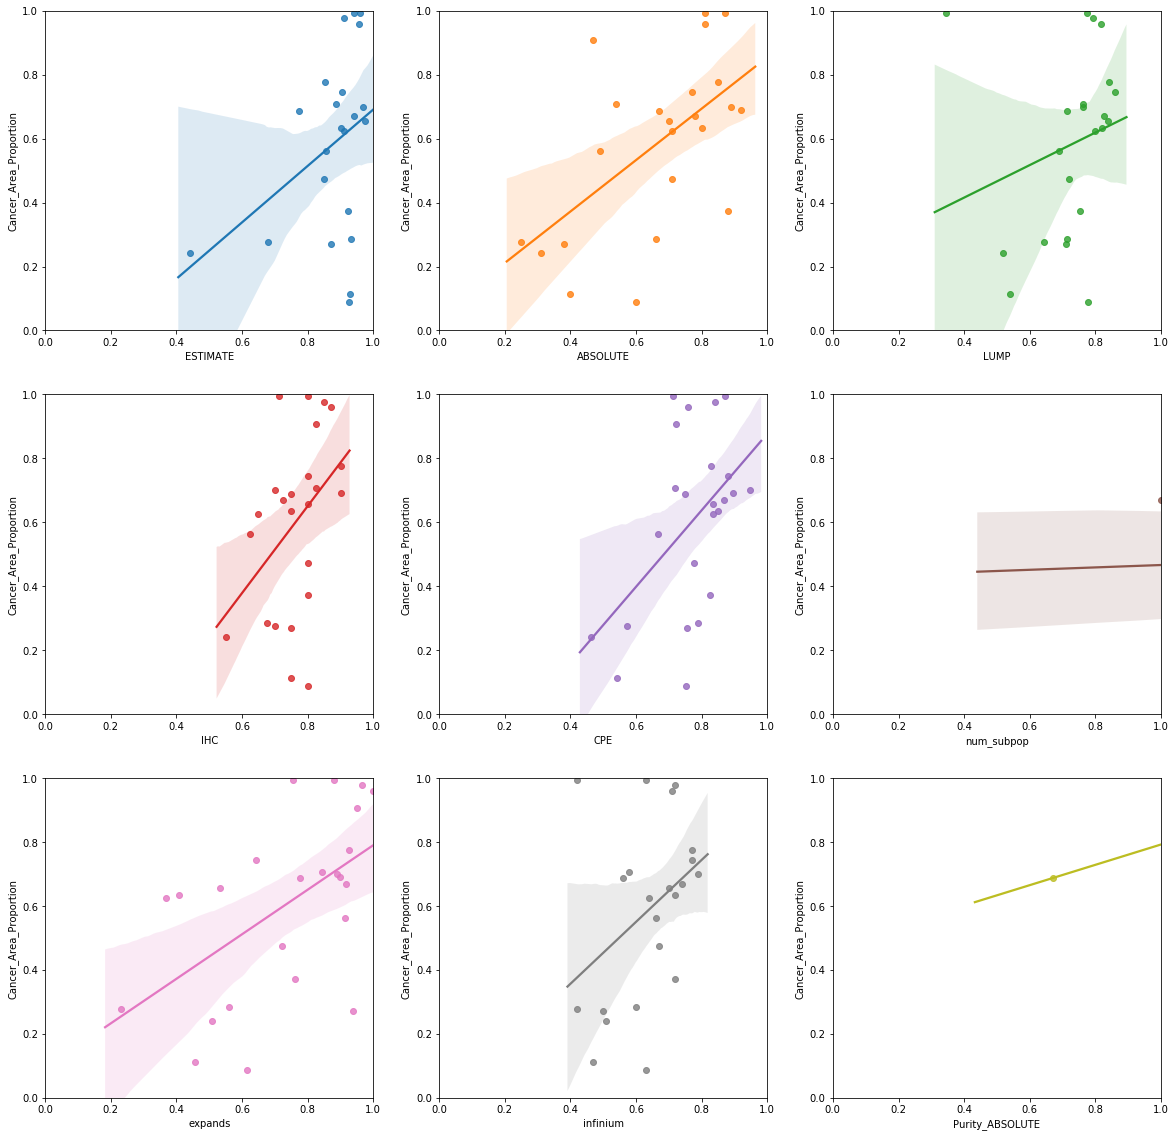

In [111]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (20,20))

columns = ['ESTIMATE', 'ABSOLUTE',
       'LUMP', 'IHC', 'CPE', 'num_subpop', 'expands', 'infinium',
       'Purity_ABSOLUTE']
for i, ax in enumerate(axs.ravel()):
    sns.regplot(x = columns[i], y = 'Cancer_Area_Proportion', ci = 95, data = combined, ax = ax)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)

ValueError: Inputs must not be empty.

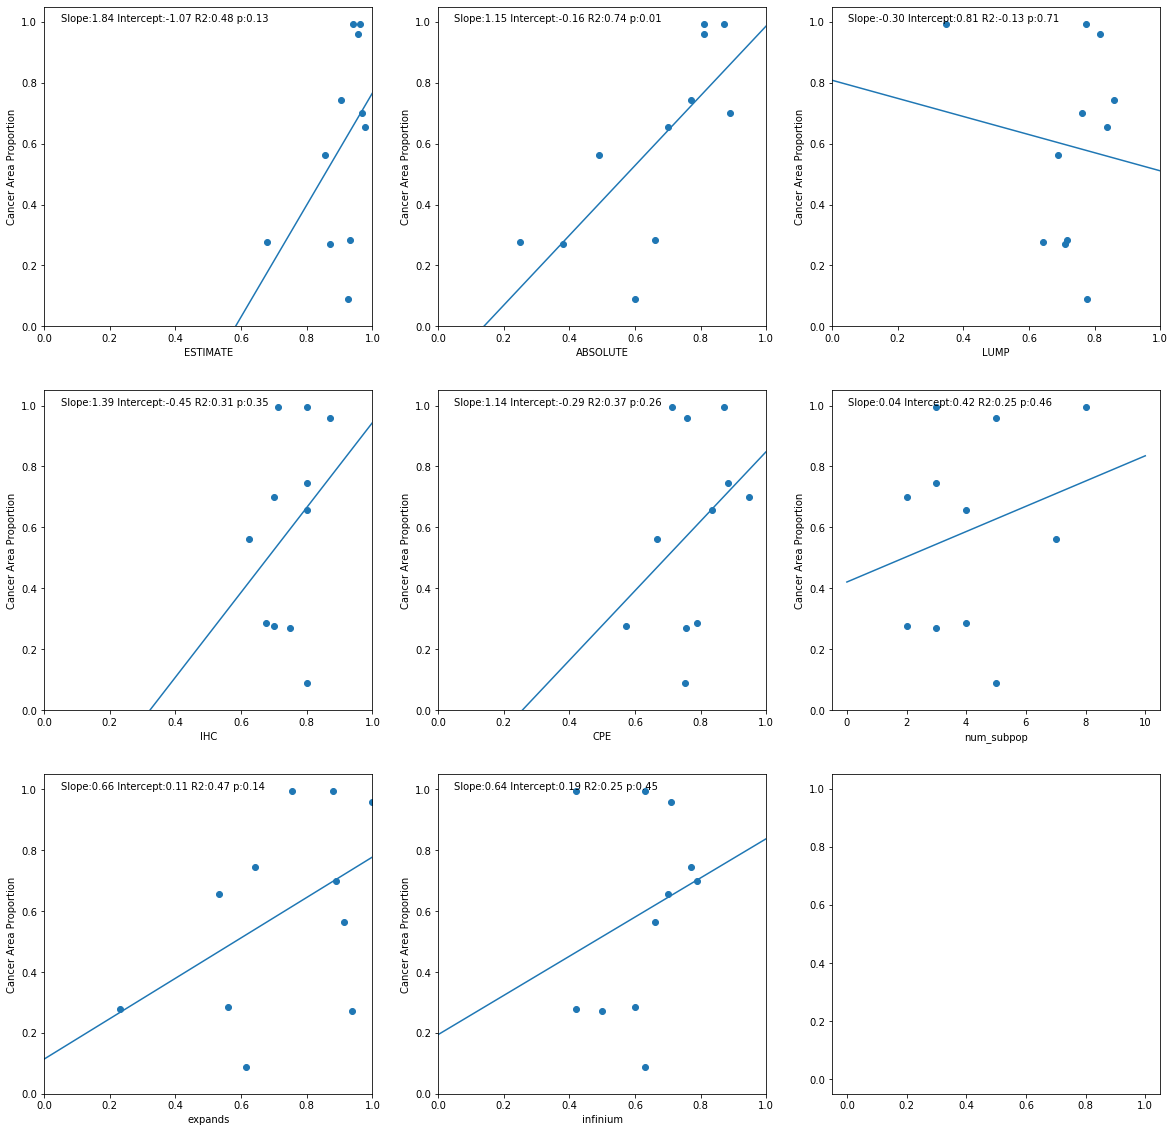

In [97]:
# Compare Cancer Area Proportion to other measures
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (20,20))

x_columns = ['ESTIMATE', 'ABSOLUTE',
       'LUMP', 'IHC', 'CPE', 'num_subpop', 'expands', 'infinium',
       'Purity_ABSOLUTE']
y_column = 'Cancer_Area_Proportion'
# y_values = combined['Average_Sigmoid_Value'].values
for i, ax in enumerate(axs.ravel()):
    x_column = x_columns[i]
    combined_filtered = combined[[x_column, y_column]].dropna()
    x_values = combined_filtered[x_column].values
    y_values = combined_filtered[y_column].values
    ax.scatter(x = x_values , y = y_values)
    linreg = sp.stats.linregress(x_values, y_values)
    ax.plot(np.linspace(0,10, 50), linreg.intercept + linreg.slope * np.linspace(0,10, 50))
    ax.text(0.05 , 1.0 , f'Slope:{linreg.slope :.2f} Intercept:{linreg.intercept :.2f} R2:{linreg.rvalue :.2f} p:{linreg.pvalue :.2f}')
#     ax.text(0.05 , 0.95 , f'p:{linreg.pvalue :.2f}')
#     print(x_values)
    ax.set_xlabel(columns[i], fontsize = 10)
    ax.set_ylabel('Cancer Area Proportion', fontsize = 10)
    ax.set_ylim(0,1.05)
    if columns[i] != 'num_subpop':
        ax.set_xlim(0,1)
#fig.tight_layout()

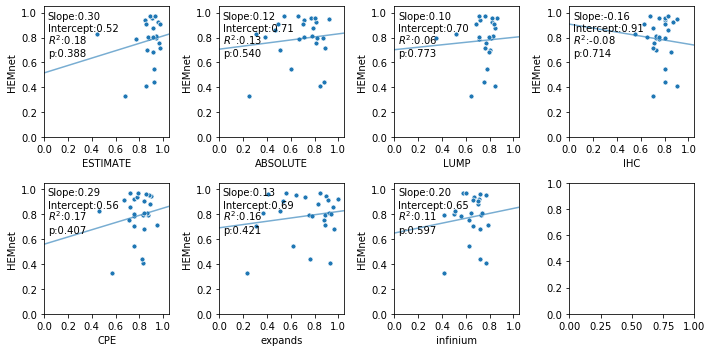

In [36]:
# Plot Cancer Area Proportion vs sequencing estimates of tumour purity
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (10,5))

x_columns = ['ESTIMATE', 'ABSOLUTE', 'LUMP', 'IHC', 'CPE', 'expands', 'infinium']
y_column = 'Cancer_Area_Proportion'
for i, ax in enumerate(axs.ravel()):
    if i !=7: 
        x_column = x_columns[i]
        combined_filtered = combined[[x_column, y_column]].dropna()
        x_values = combined_filtered[x_column].values
        y_values = combined_filtered[y_column].values
        sns.scatterplot(x = x_values , y = y_values, s=25, ax=ax)
        # Plot line of best fit
        linreg = sp.stats.linregress(x_values, y_values)
        sns.lineplot(np.linspace(0,10, 50), linreg.intercept + linreg.slope * np.linspace(0,10, 50), alpha=0.6, ax=ax)
        # Overlay line of best fit parameters
        x_offset = 0.03
        y_offset = 0.95
        spacing = 0.1
        ax.text(x_offset, y_offset, f'Slope:{linreg.slope :.2f}')
        ax.text(x_offset, y_offset - spacing, f'Intercept:{linreg.intercept :.2f}')
        ax.text(x_offset, y_offset - 2 * spacing , f'$R^2$:{linreg.rvalue :.2f}')
        ax.text(x_offset, y_offset - 3 * spacing, f'p:{linreg.pvalue :.3f}')
        ax.set_xticks(np.arange(0, 1.2, 0.2))
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.set_xlabel(x_columns[i])
        ax.set_ylabel('HEMnet')
        ax.set_ylim(0,1.05)
        ax.set_xlim(0,1.05)
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
verbose_save_fig(fig, OUTPUT_PATH.joinpath('HEMnet_vs_seq_purity_scatterplot.svg'))

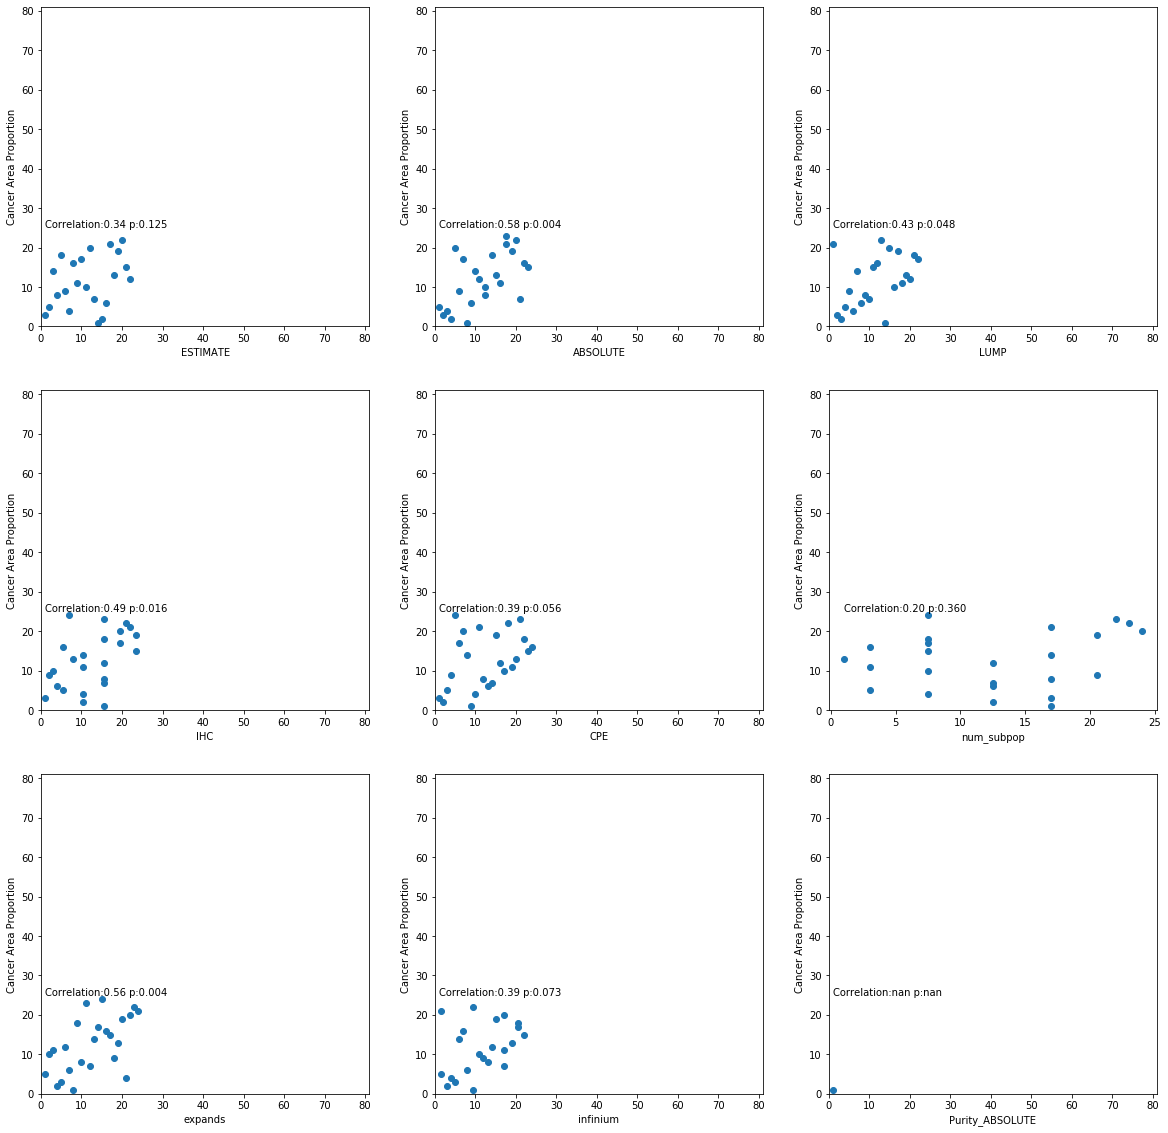

In [24]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (20,20))

x_columns = ['ESTIMATE', 'ABSOLUTE',
       'LUMP', 'IHC', 'CPE', 'num_subpop', 'expands', 'infinium',
       'Purity_ABSOLUTE']
y_column = 'Cancer_Area_Proportion'
# y_values = combined['Average_Sigmoid_Value'].values
for i, ax in enumerate(axs.ravel()):
    x_column = x_columns[i]
    combined_filtered = combined[[x_column, y_column]].dropna()
    x_values = combined_filtered[x_column].values
    y_values = combined_filtered[y_column].values
    x_rank = sp.stats.rankdata(x_values)
    y_rank = sp.stats.rankdata(y_values)
    ax.scatter(x = x_rank , y = y_rank)
    linreg = sp.stats.spearmanr(x_values, y_values)
    #ax.plot(np.linspace(0,10, 50), linreg.intercept + linreg.slope * np.linspace(0,10, 50))
    ax.text(1 , 25.0 , f'Correlation:{linreg.correlation :.2f} p:{linreg.pvalue :.3f}')
#     ax.text(0.05 , 0.95 , f'p:{linreg.pvalue :.2f}')
#     print(x_values)
    ax.set_xlabel(columns[i], fontsize = 10)
    ax.set_ylabel('Cancer Area Proportion', fontsize = 10)
    ax.set_ylim(0,81)
    if columns[i] != 'num_subpop':
        ax.set_xlim(0,81)
#fig.tight_layout()

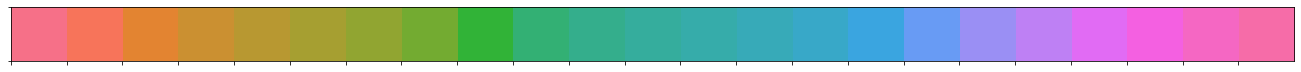

In [25]:
# Make a list of colors where each slide has a unique color
# cmap = plt.cm.tab30(np.arange(len(x_values)))
sns.palplot(sns.color_palette('husl', 23))

In [35]:
combined_filtered

,ABSOLUTE,Cancer_Area_Proportion
ID,,
A6-5656,0.81,0.994096
A6-6650,0.81,0.959655
AA-3715,0.47,0.906945
AA-3973,0.92,0.690780
AD-6889,0.87,0.993960
AZ-4615,0.67,0.687635
AZ-4682,0.78,0.669187
AZ-5403,0.38,0.270921
CA-6715,0.89,0.700154


[0.81 0.81 0.82 0.51 0.79 0.47 0.92 0.87 0.67 0.78 0.38 0.89 0.71 0.77
 0.85 0.8  0.54 0.25 0.49 0.71 0.31 0.66 0.6  0.7  0.88]


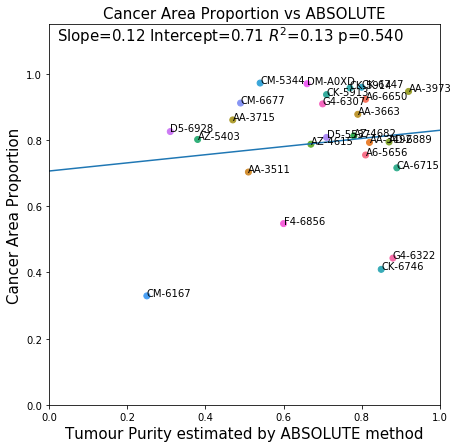

In [37]:
fig, ax = plt.subplots(figsize = (7,7))
x_column = 'ABSOLUTE'
y_column = 'Cancer_Area_Proportion'
combined_filtered = combined[[x_column, y_column]].dropna()
x_values = combined_filtered[x_column].values
y_values = combined_filtered[y_column].values

print(x_values)

ax.scatter(x = x_values, y = y_values, c = sns.color_palette('husl', len(x_values)))
linreg = sp.stats.linregress(x_values, y_values)
ax.plot(np.linspace(0,10, 50), linreg.intercept + linreg.slope * np.linspace(0,10, 50))
ax.text(0.02 , 1.1 , f'Slope={linreg.slope :.2f} Intercept={linreg.intercept :.2f} $R^2$={linreg.rvalue :.2f} p={linreg.pvalue :.3f}'
       , fontsize = 15)
ax.set_xlabel(f'Tumour Purity estimated by {x_column} method', fontsize = 15)
ax.set_ylabel('Cancer Area Proportion', fontsize = 15)
ax.set_title(f'Cancer Area Proportion vs {x_column}', fontsize = 15)
ax.set_xlim(0,1)
ax.set_ylim(0,1.15)

for i, txt in enumerate(combined_filtered.index.values):
    ax.annotate(txt, (x_values[i], y_values[i]))

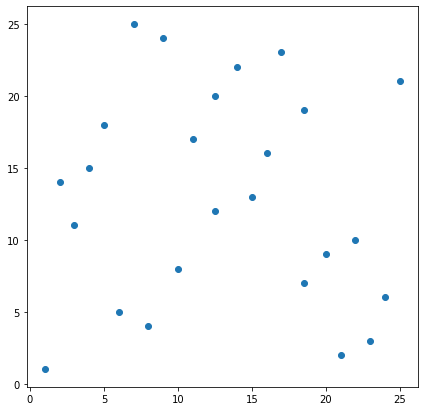

In [38]:
fig, ax = plt.subplots(figsize = (7,7))
x_column = 'ABSOLUTE'
y_column = 'Cancer_Area_Proportion'
combined_filtered = combined[[x_column, y_column]].dropna()
x_values = combined_filtered[x_column].values
y_values = combined_filtered[y_column].values
x_rank = sp.stats.rankdata(x_values)
y_rank = sp.stats.rankdata(y_values)
ax.scatter(x = x_rank, y = y_rank)

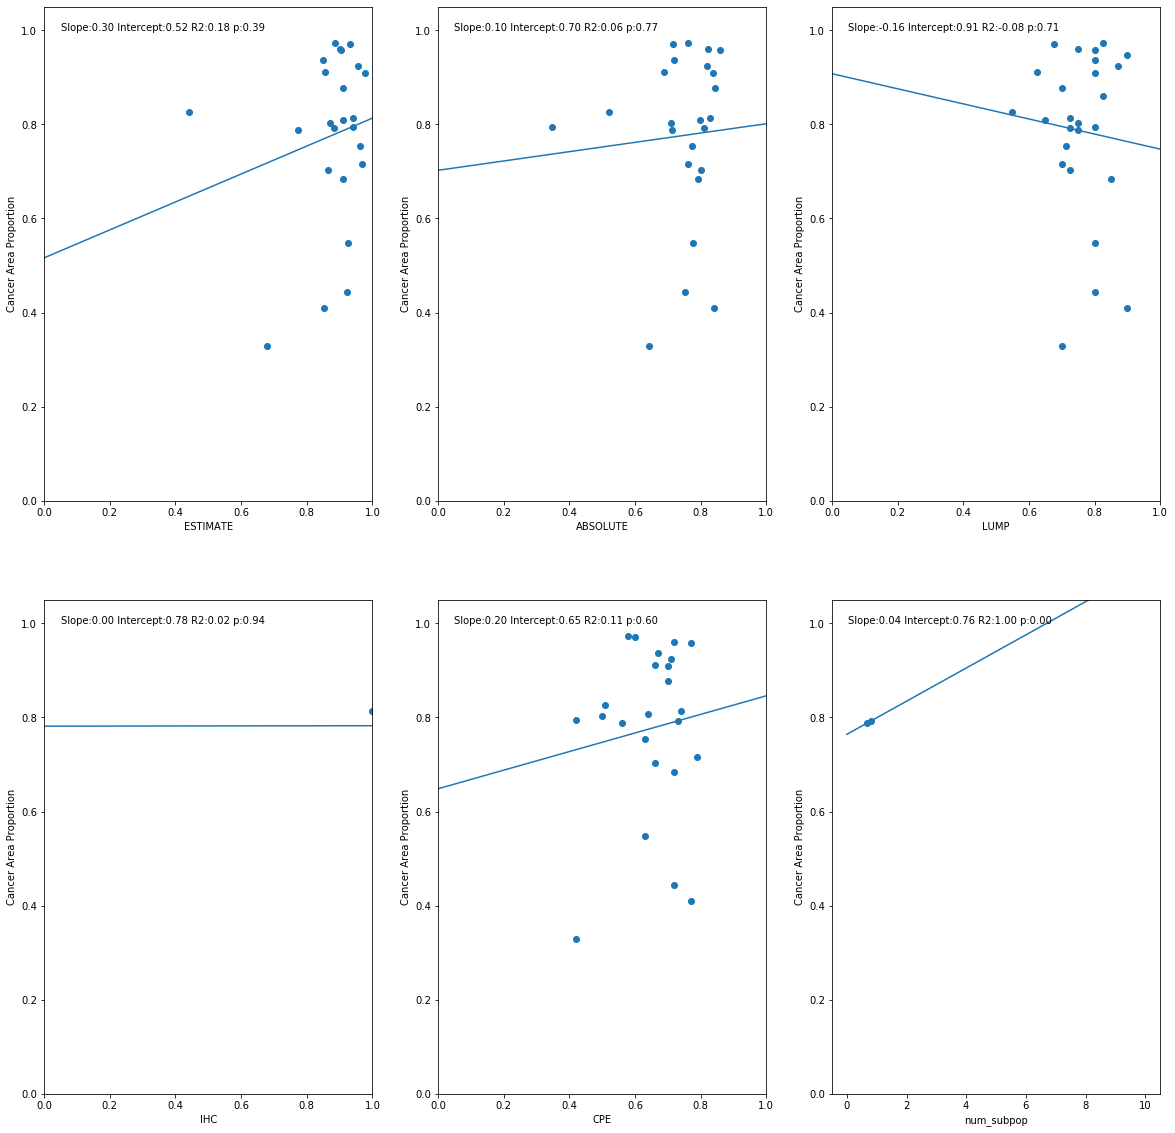

In [39]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (20,20))

x_columns = ['ESTIMATE',
       'LUMP', 'IHC', 'num_subpop', 'infinium',
       'Purity_ABSOLUTE']
y_column = 'Cancer_Area_Proportion'
# y_values = combined['Average_Sigmoid_Value'].values
for i, ax in enumerate(axs.ravel()):
    x_column = x_columns[i]
    combined_filtered = combined[[x_column, y_column]].dropna()
    x_values = combined_filtered[x_column].values
    y_values = combined_filtered[y_column].values
    ax.scatter(x = x_values , y = y_values)
    linreg = sp.stats.linregress(x_values, y_values)
    ax.plot(np.linspace(0,10, 50), linreg.intercept + linreg.slope * np.linspace(0,10, 50))
    ax.text(0.05 , 1.0 , f'Slope:{linreg.slope :.2f} Intercept:{linreg.intercept :.2f} R2:{linreg.rvalue :.2f} p:{linreg.pvalue :.2f}')
#     ax.text(0.05 , 0.95 , f'p:{linreg.pvalue :.2f}')
#     print(x_values)
    ax.set_xlabel(columns[i], fontsize = 10)
    ax.set_ylabel('Cancer Area Proportion', fontsize = 10)
    ax.set_ylim(0,1.05)
    if columns[i] != 'num_subpop':
        ax.set_xlim(0,1)
#fig.tight_layout()
plt.show()

(0, 1)

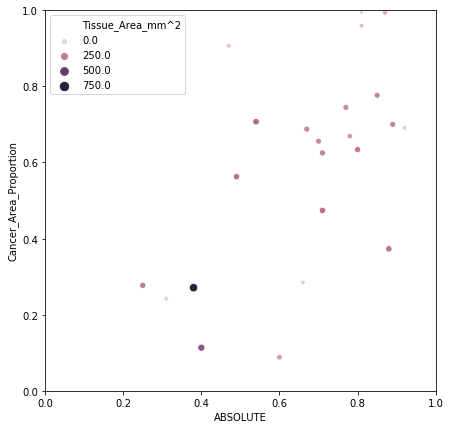

In [29]:
fig, ax = plt.subplots(figsize = (7,7))
sns.scatterplot(x = 'ABSOLUTE', y = 'Cancer_Area_Proportion', hue = 'Tissue_Area_mm^2', size = 'Tissue_Area_mm^2', 
                data = combined, ax = ax)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

(0, 1)

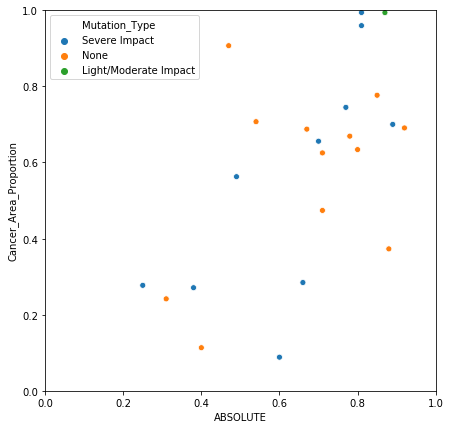

In [150]:
fig, ax = plt.subplots(figsize = (7,7))
combined_filtered = combined
combined_filtered['Mutation_Type'] = combined_filtered['Mutation_Type'].replace({
    'Missense_Mutation': 'Severe Impact',
    'Nonsense_Mutation': 'Severe Impact',
    "3'UTR": 'Light/Moderate Impact'
})
sns.scatterplot(x='ABSOLUTE', y='Cancer_Area_Proportion', hue='Mutation_Type', 
                data = combined_filtered, ax = ax)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

In [30]:
# Filter combined by tissue area
combined_minarea = combined.loc[combined['Tissue_Area_mm^2'] > 50]

NameError: name 'combined_minarea' is not defined

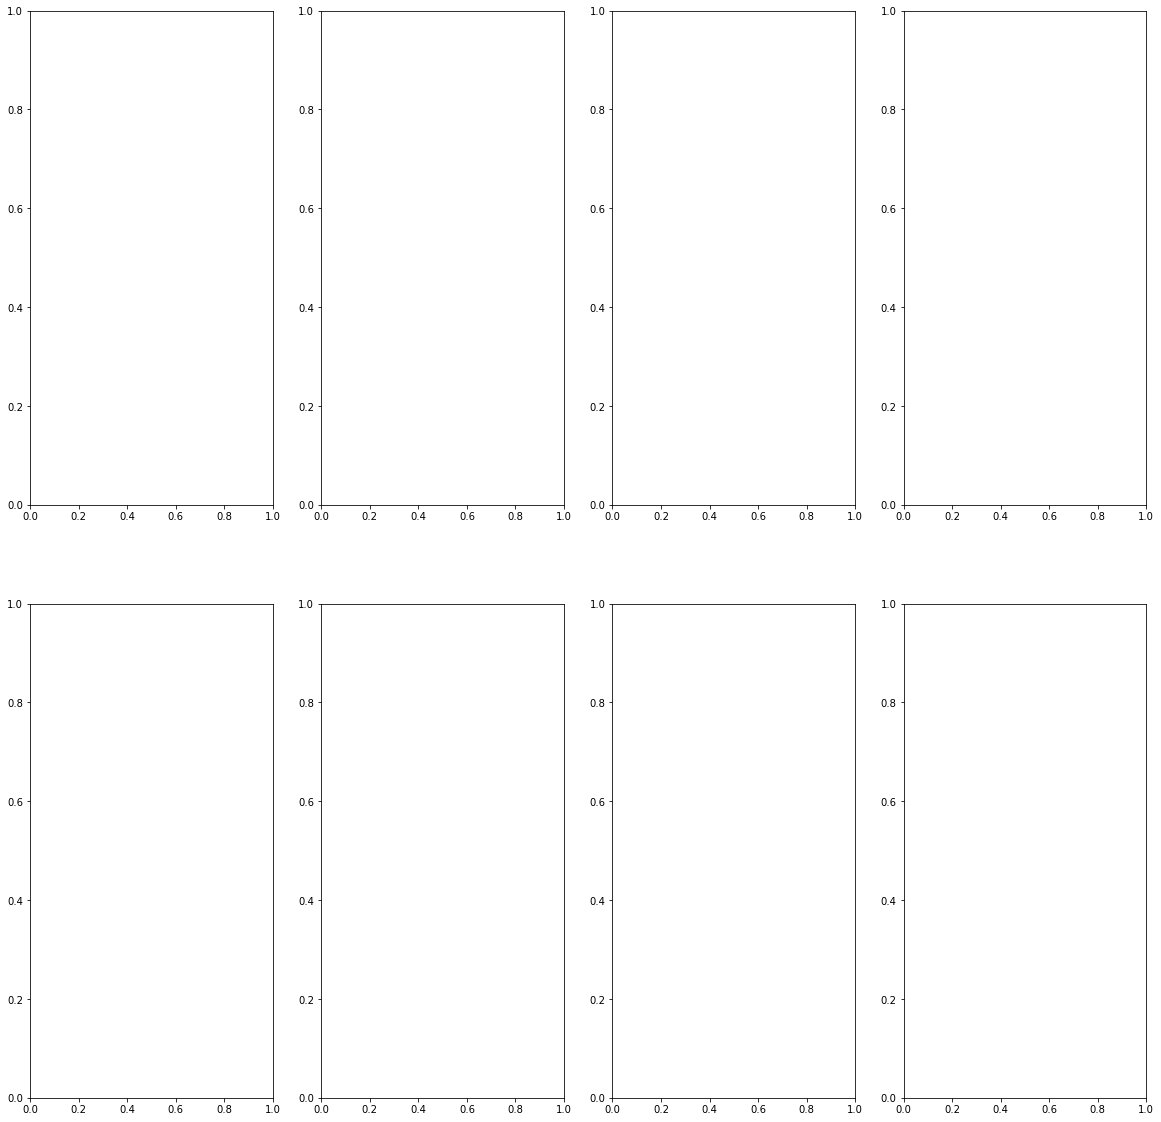

In [36]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (20,20))

y_columns = ['ESTIMATE', 'ABSOLUTE',
       'LUMP', 'IHC', 'CPE', 'num_subpop', 'expands', 'infinium',
       'Purity_ABSOLUTE']
x_column = 'Cancer_Area_Proportion'
for i, ax in enumerate(axs.ravel()):
    y_column = y_columns[i]
    combined_filtered = combined_minarea[[x_column, y_column, 'Tissue_Area_mm^2']].dropna()
    x_values = combined_filtered[x_column].values
    y_values = combined_filtered[y_column].values
    sns.scatterplot(x = x_column , y = y_column, hue = 'Tissue_Area_mm^2', size = 'Tissue_Area_mm^2', 
                data = combined_filtered, ax = ax)
    linreg = sp.stats.linregress(x_values, y_values)
    ax.plot(np.linspace(0,10, 50), linreg.intercept + linreg.slope * np.linspace(0,10, 50))
    ax.text(0.05 , 0.95 , f'Slope:{linreg.slope :.2f} Intercept:{linreg.intercept :.2f} R2:{linreg.rvalue :.2f} p:{linreg.pvalue :.2f}')
    ax.set_xlabel(columns[i], fontsize = 10)
    ax.set_ylabel('Cancer Area Proportion', fontsize = 10)
    ax.set_ylim(0,1)
    if columns[i] != 'num_subpop':
        ax.set_xlim(0,1)
    ax.legend(loc = 'lower right')
#fig.tight_layout()

## Plot heatmap of correlations

In [78]:
methods = ['ESTIMATE', 'ABSOLUTE','LUMP', 'IHC', 'CPE', 'expands', 'infinium', 'Cancer_Area_Proportion']
combined_methods_corr = combined[methods].corr(method='pearson')

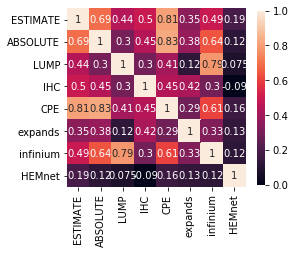

In [79]:
fig = plt.figure(figsize=(4, 4))
labels = ['ESTIMATE', 'ABSOLUTE','LUMP', 'IHC', 'CPE', 'expands', 'infinium', 'HEMnet']
sns.heatmap(combined_methods_corr, square=True, annot=True, vmin=0, vmax=1
            , xticklabels=labels, yticklabels=labels, cbar_kws={'shrink':0.8})
plt.rcParams['svg.fonttype'] = 'none'
verbose_save_fig(fig, OUTPUT_PATH.joinpath('HEMnet_vs_seq_purity_pearson_corr_heatmap.svg'))

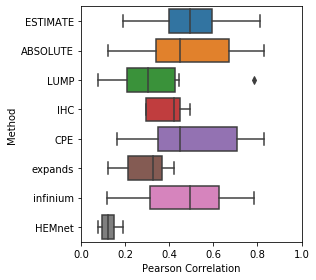

In [80]:
fig, ax = plt.subplots(figsize=(4.5, 4))
sns.boxplot(data=combined_methods_corr[combined_methods_corr != 1], ax=ax, orient='h')
ax.set_xlim(0,1)
ax.set_yticklabels(labels)
ax.set_xlabel('Pearson Correlation')
ax.set_ylabel('Method')
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
verbose_save_fig(fig, OUTPUT_PATH.joinpath('HEMnet_vs_seq_purity_pearson_corr_boxplot.svg'))

In [50]:
methods = ['ESTIMATE', 'ABSOLUTE',
       'LUMP', 'IHC', 'CPE', 'expands', 'infinium', 'Cancer_Area_Proportion']
array_size = (len(methods), len(methods))
slopes = np.zeros(array_size)
p_values = np.zeros(array_size)

row, col = 0, 0

for row_method in methods:
    for col_method in methods:
        if row_method == col_method:
            slope, p_value = 1, 0
        else:
            combined_filtered = combined[[row_method, col_method]].dropna()
            row_method_values = combined_filtered[row_method].values
            col_method_values = combined_filtered[col_method].values
            linreg = sp.stats.linregress(row_method_values, col_method_values)
            slope = linreg.slope
            p_value = linreg.pvalue
        slopes[row, col] = slope
        p_values[row, col] = p_value
        col += 1
    col = 0
    row += 1

In [51]:
slopes_df = pd.DataFrame(slopes, index=methods, columns=methods)
slopes_df = slopes_df.rename(columns={'expands': 'Expands', 'infinium': 'Infinium', 'Cancer_Area_Proportion': 'Cancer Area Proportion'})

In [52]:
hmap_colours = [(0, 0, 0, 1) if p_value < 0.05 else (1, 1, 1, 1) for p_value in p_values.ravel()]

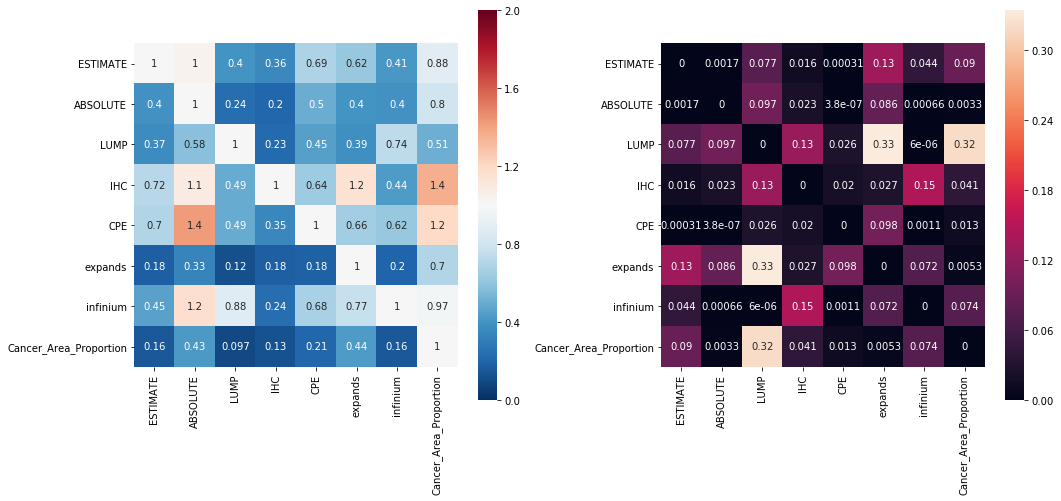

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.heatmap(slopes, cmap='RdBu_r', vmin=0, vmax=2, center=1.0, annot=True, square=True,
           xticklabels=methods, yticklabels=methods, ax = axs[0])
sns.heatmap(p_values, vmin=0, annot=True, square=True,
           xticklabels=methods, yticklabels=methods, ax = axs[1])
fig.tight_layout()

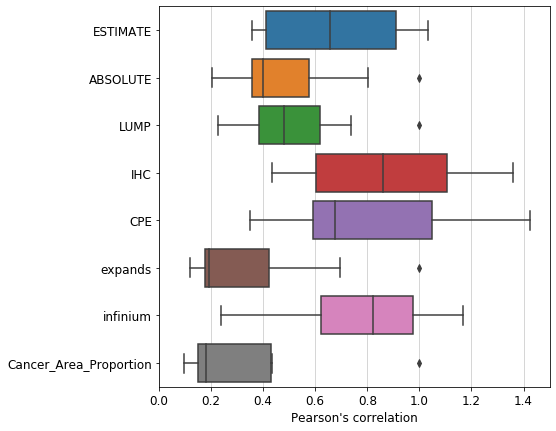

In [57]:
fig, ax = plt.subplots(figsize=(7, 7))

# Add a vertical grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax.xaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.4)
# Hide these grid behind plot objects
ax.set_axisbelow(True)

sns.boxplot(data=slopes_df.T, orient='h')
ax.set_xlim((0,1.5))
ax.set_xlabel("Pearson's correlation", fontsize=12)
# ax.set_title("Comparison of correlations between tumour purity estimation methods", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
# ax.set_ylabel('Tumour Purity Estimation Methods')

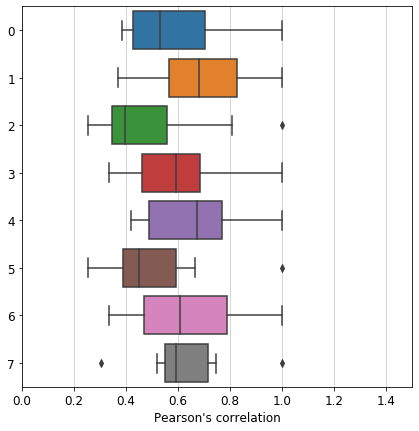

In [56]:
fig, ax = plt.subplots(figsize=(7, 7))

# Add a vertical grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax.xaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.4)
# Hide these grid behind plot objects
ax.set_axisbelow(True)

sns.boxplot(data=(slopes + slopes.T)/2, orient='h')
ax.set_xlim((0,1.5))
ax.set_xlabel("Pearson's correlation", fontsize=12)
# ax.set_title("Comparison of correlations between tumour purity estimation methods", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
# ax.set_ylabel('Tumour Purity Estimation Methods')

In [38]:
(slopes + slopes.T)/2

array([[1.        , 0.71603952, 0.38506296, 0.54060192, 0.69753971,
        0.39797724, 0.43454368, 0.51910324],
       [0.71603952, 1.        , 0.4085714 , 0.64731062, 0.96300098,
        0.36741709, 0.78282238, 0.61533617],
       [0.38506296, 0.4085714 , 1.        , 0.36029673, 0.4733245 ,
        0.25431312, 0.80866629, 0.30278203],
       [0.54060192, 0.64731062, 0.36029673, 1.        , 0.4935775 ,
        0.66487583, 0.33589734, 0.74512348],
       [0.69753971, 0.96300098, 0.4733245 , 0.4935775 , 1.        ,
        0.4187212 , 0.65058732, 0.70263235],
       [0.39797724, 0.36741709, 0.25431312, 0.66487583, 0.4187212 ,
        1.        , 0.48328398, 0.56634747],
       [0.43454368, 0.78282238, 0.80866629, 0.33589734, 0.65058732,
        0.48328398, 1.        , 0.56214447],
       [0.51910324, 0.61533617, 0.30278203, 0.74512348, 0.70263235,
        0.56634747, 0.56214447, 1.        ]])